In [56]:
main_dir = '/Users/simon/bsose_monthly/'
salt = main_dir + 'bsose_i106_2008to2012_monthly_Salt.nc'
theta = main_dir + 'bsose_i106_2008to2012_monthly_Theta.nc'

%load_ext autoreload
%autoreload 2
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature
import matplotlib.path as mpath
import os, sys
sys.path.insert(0, os.path.abspath('..'))

import pyxpcm
from pyxpcm.models import pcm
import sithom_plot_style as sps


def pcm_fit_and_post(time_i=42, K=4, maxvar=2):  
    # Define features to use
    # Instantiate the PCM
    
    max_depth = 2000
    z = np.arange(0., -max_depth, -10.)
    features_pcm = {'THETA': z, 'SALT': z}
    features = {'THETA': 'THETA', 'SALT': 'SALT'}
    salt_nc = xr.open_dataset(salt).isel(time=time_i)
    theta_nc = xr.open_dataset(theta).isel(time=time_i)
    big_nc = xr.merge([salt_nc, theta_nc])
    both_nc = big_nc.where(big_nc.coords['Depth'] > 
                           max_depth).drop(['iter', 'Depth', 
                                            'rA', 'drF', 'hFacC'])   
 
    attr_d = {}

    for coord in both_nc.coords:
        attr_d[coord] = both_nc.coords[coord].attrs
        
    lons_new = np.linspace(both_nc.XC.min(), both_nc.XC.max(), 60*4)
    lats_new = np.linspace(both_nc.YC.min(), both_nc.YC.max(), 60)
    ds = both_nc # .copy(deep=True)
    #ds = both_nc.interp(coords={'YC': lats_new, 'XC': lons_new})#, method='cubic')
        
    m = pcm(K=K, features=features_pcm, 
            maxvar=maxvar, 
            #timeit=True, timeit_verb=1, 
            separate_pca=False)
    m.fit(ds, features=features, dim='Z')
    m.find_i_metric(ds, inplace=True)
    
    def sanitize():
        #del ds.PCM_LABELS.attrs['_pyXpcm_cleanable']
        #del ds.PCM_POST.attrs['_pyXpcm_cleanable']
        # del ds.PCM_RANK.attrs['_pyXpcm_cleanable']
        del ds.IMETRIC.attrs['_pyXpcm_cleanable']
        del ds.A_B.attrs['_pyXpcm_cleanable']
        
    for coord in attr_d:
        ds.coords[coord].attrs = attr_d[coord]
    
    sanitize()
    ds = ds.drop(['THETA', 'SALT'])   
 
    return ds, m

def plot_so(xr_da):

    map_proj = ccrs.SouthPolarStereo()
    carree = ccrs.PlateCarree()

    fig = plt.figure(figsize=[5, 5])

    ax1 = plt.subplot(1, 1, 1, projection=map_proj)
    fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, 
                        wspace=0.02)
    ax1.set_extent([-180, 180, -90, -30], carree)
    
    def plot_boundary():
        theta = np.linspace(0, 2 * np.pi, 100)
        center, radius = [0.5, 0.5], 0.45
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)
        ax1.set_boundary(circle, transform=ax1.transAxes)
    
    plot_boundary()
    
    sps.ds_for_graphing(xr_da.to_dataset()).to_array().plot(
               transform=carree,                      # the data's projection
               ax=ax1,
               subplot_kws={"projection": map_proj},  # the plot's projection
               cbar_kwargs={"shrink": 0.3},
               )
    
    ax1.coastlines()
    """
    ax1.gridlines(xlocs=range(-int(xr_ds.XC.values.min()), 
                              int(xr_ds.XC.values.max()), 45), 
                  ylocs=range(-80, -19, 20))
                             
    """
    
    #plt.savefig('i_metric_example.pdf')
    

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
ds, m = pcm_fit_and_post(time_i=42, K=4, maxvar=2)

Fitting PCA
[(0, 0), (1, 0), (1, 1), (2, 0), (2, 1), (2, 2), (3, 0), (3, 1), (3, 2), (3, 3)]
(800124, 2)


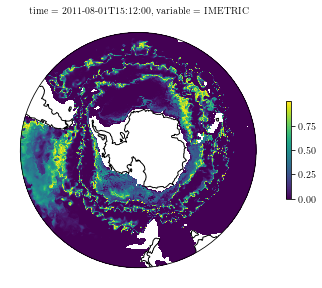

In [55]:
plot_so(ds.IMETRIC.isel(Imetric=0))


In [18]:
for var in ds.variables:
    if var in ['I_METRIC', 'A_B']:
        ds.variables[var]

In [32]:
ds.I_METRIC.isel(Imetric=0)

<xarray.DataArray 'I_METRIC' (YC: 60, XC: 240)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., nan, ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
    time     datetime64[ns] 2011-08-01T15:12:00
  * YC       (YC) float64 -77.98 -77.16 -76.35 -75.53 ... -31.35 -30.53 -29.72
  * XC       (XC) float64 0.08333 1.589 3.094 4.6 ... 355.4 356.9 358.4 359.9
Attributes:
    long_name:  I metric
    units:      
    valid_min:  0
    valid_max:  1

In [31]:
ds.I_METRIC.isel(Imetric=0)

<xarray.DataArray 'I_METRIC' (YC: 60, XC: 240)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0., nan, ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
    time     datetime64[ns] 2011-08-01T15:12:00
  * YC       (YC) float64 -77.98 -77.16 -76.35 -75.53 ... -31.35 -30.53 -29.72
  * XC       (XC) float64 0.08333 1.589 3.094 4.6 ... 355.4 356.9 358.4 359.9
Attributes:
    long_name:  I metric
    units:      
    valid_min:  0
    valid_max:  1

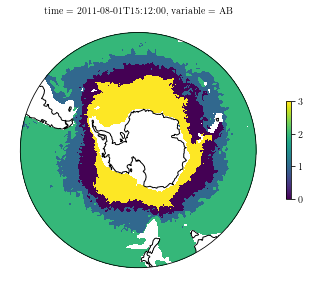

In [53]:
plot_so(ds.A_B.rename('AB').isel(rank=0))


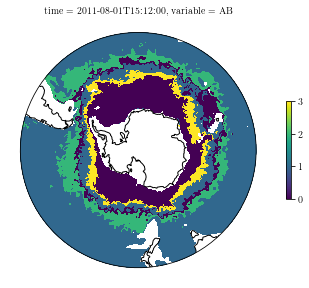

In [54]:
plot_so(ds.A_B.rename('AB').isel(rank=1))
